<a href="https://colab.research.google.com/github/ArielFix/DLINtroProject/blob/main/NLP_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from IPython.display import HTML
import subprocess

branch = subprocess.check_output(["git", "rev-parse", "--abbrev-ref", "HEAD"]).decode()[:-1]
HTML('<a href="https://colab.research.google.com/github/ArielFix/DLINtroProject/blob/{branch}/NLP_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>'.format(branch=branch))

CalledProcessError: ignored

## Setup Commands

In [ ]:
!git init .
!git remote add origin https://github.com/ArielFix/DLINtroProject.git
!git fetch
!git checkout main

In [1]:
%load_ext autoreload
%autoreload 2

In [54]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import model_selection
from sklearn.metrics import f1_score
import numpy as np
import torch
from torch.utils.data import dataset
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [3]:
from google.colab import drive
import os
import sys

drive.mount('/content/gdrive')
train_path = '/content/gdrive/MyDrive/NLP_Project/data/train.csv'
test_path = '/content/gdrive/My Drive/NLP_Project/data/test.csv'
sample_submission_path = '/content/gdrive/MyDrive/NLP_Project/data/sample_submission.csv'

GOOGLE_DRIVE_PATH = '/content/gdrive/MyDrive/NLP_Project'
sys.path.append(GOOGLE_DRIVE_PATH)
print(os.listdir(GOOGLE_DRIVE_PATH))

Mounted at /content/gdrive
['data', 'README.md', 'test_augs.py', 'requirements.txt', 'get_roberta_model.py', 'pretrained', 'utilities', 'roberta', 'augmentations', 'NLP_Project.ipynb', '.gitignore', '.idea', 'NLP_Project Roberta.ipynb']


In [48]:
!echo "This may take a while:"
# For colab run:
#%pip install -q -r /content/gdrive/MyDrive/NLP_Project/requirements.txt # fill here the path to the requirement file
# For Local run:
%pip install -q -r requirements.txt 


"This may take a while:"
Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\ariel\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [49]:
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


**A quick look at our data**
Let's look at our data... first, some examples of what is NOT a disaster tweet.

In [50]:
print('\n' .join(map(str, train_df[train_df["target"] == 0]["text"].values[0:5])))


What's up man?
I love fruits
Summer is lovely
My car is so fast
What a goooooooaaaaaal!!!!!!


And some examples of what is a disaster tweet.

In [51]:
print('\n' .join(map(str, train_df[train_df["target"] == 1]["text"].values[0:5])))

Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
Forest fire near La Ronge Sask. Canada
All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected
13,000 people receive #wildfires evacuation orders in California 
Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school 


The words contained in each tweet are a good indicator of whether they're about a real disaster or not. This is not entirely correct, but it's a great place to start.

We'll use scikit-learn's 'train_test_split' for splitting the train data to train and validation sets for monitoring the model training.

In [52]:
train_df, val_df = model_selection.train_test_split(train_df, test_size=0.15, train_size=0.85)

**Our model**

As we mentioned above, we think the words contained in each tweet are a good indicator of whether they're about a real disaster or not. The presence of particular word (or set of words) in a tweet might link directly to whether or not that tweet is real.

We want to modify [twitter-roberta-sentiment](https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment) for the classification task of disaster tweets.
First let's load the pretrained model

In [53]:
from pretrained.get_pretrained_roberta import GetPretrainedRoberta 

roberta = GetPretrainedRoberta() #init pretrained roberta model and tokenizer
roberta.model.modules # Shows model's modules

<bound method Module.modules of RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, 

Now, we want our model output layer to be the results o a sigmoid layer, this sigmoid layer should get only one value from the last linear layer.
We will change the linear layer 'out'proj' with 3 outputs into a sequenc which includes the same input size, output size of 1 and a sigmoid.
Additioanly, we want to fine tune the pretained roberta model with the new output layer so we will freeze the entire model except the 'Classifier' module which includes the last layer.  

In [55]:
from pretrained.modify_roberta import ModifyRoberta

ModifyRoberta.modify_binary_output(roberta.model) #change output layer to linear -> sigmoid
ModifyRoberta.modify_only_train_calssifier(roberta.model) #freeze the parameters except the 'Classifier' module
roberta.model.modules


<bound method Module.modules of RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, 

Now we should preprocess and prepare the data for the model training

In [56]:
from utilities.preprocess import Utilities

train_text, train_target = train_df['text'].to_list(), train_df['target']
Utilities().preprocess_text_list(train_text)
train_data = pd.DataFrame()
train_data['text'], train_data['target'] = train_text, train_df['target']
val_text = val_df['text'].to_list()
Utilities().preprocess_text_list(val_text)
val_data = pd.DataFrame()
val_data['text'], val_data['target'] = val_text, val_df['target']

val_data.dropna(axis=0, inplace=True)
val_data.reset_index(drop=True, inplace=True)
train_data.dropna(axis=0, inplace=True)
train_data.reset_index(drop=True, inplace=True)


And let's see how a sample data tokenized by the tokenizer

In [57]:
roberta.tokenizer(train_data['text'][train_data.index[0:3]].to_list(), return_tensors='pt', padding=True)

{'input_ids': tensor([[    0,   108, 18975, 12621,    54,   376,    11,   200,   955,  3163,
          1811, 24853,     2,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1],
        [    0, 27077,  7279, 10074,    30,  6299,    23,     5,  9660,  5455,
            71,   305, 13286,  3465, 18238,  1241, 22998,   272, 15098,   111,
          1666,  2054,     2,     1,     1,     1,     1,     1],
        [    0,   627,  2508, 10868, 10879, 34876,   127,   490,  2931,     8,
           122,   127,   741,  1657,    16,    11,  3745,    95,   277,  1246,
             9,  2574,    18, 34239,     7,  1050,  3606,     2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
         0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       

We can notice that the tokenizer creates two tensors:  
1. 'input_ids' - includes the word indexes from the dictioanry, we can also see that padding uses '1' to equalize the tensor's second dimension length.
2. 'attention_mask' - includes the mask for the 'input_ids' tensor, which includes '1' for actual word in 'input_ids' and '0' for padded values in it.

Now we will verify that our modified model enable to overfit a sample of the training data:

In [58]:
from roberta.roberta_handle import RobertaHandler as RH

handler = RH()
try_train = handler.train_roberta_model(val_data=train_data[0:15] ,batch_size=15, check_point_path=None, learning_rate=1e-3, num_epoches=20, train_data=train_data[0:15], model=roberta)

====> Epoch: 0 Average train loss: 0.0328, train acc: 1.0000, Average val loss: 0.0007, val acc: 1.0000
====> Epoch: 1 Average train loss: 0.0010, train acc: 1.0000, Average val loss: 0.0001, val acc: 1.0000
====> Epoch: 2 Average train loss: 0.0001, train acc: 1.0000, Average val loss: 0.0000, val acc: 1.0000
====> Epoch: 3 Average train loss: 0.0000, train acc: 1.0000, Average val loss: 0.0000, val acc: 1.0000
====> Epoch: 4 Average train loss: 0.0000, train acc: 1.0000, Average val loss: 0.0000, val acc: 1.0000
====> Epoch: 5 Average train loss: 0.0000, train acc: 1.0000, Average val loss: 0.0000, val acc: 1.0000
====> Epoch: 6 Average train loss: 0.0000, train acc: 1.0000, Average val loss: 0.0000, val acc: 1.0000
====> Epoch: 7 Average train loss: 0.0000, train acc: 1.0000, Average val loss: 0.0000, val acc: 1.0000
====> Epoch: 8 Average train loss: 0.0000, train acc: 1.0000, Average val loss: 0.0000, val acc: 1.0000
====> Epoch: 9 Average train loss: 0.0000, train acc: 1.0000, Av

Let's plot the training and validation acuracies and losses

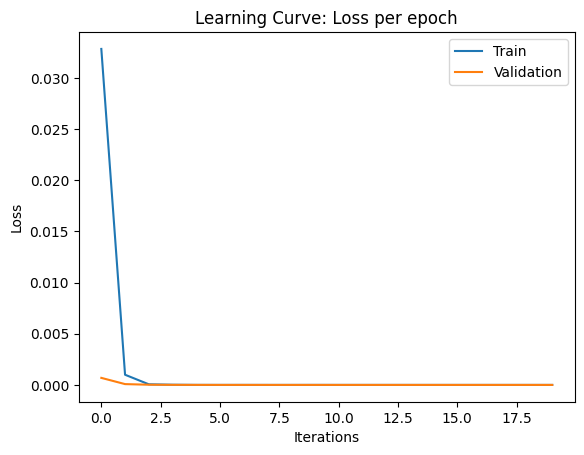

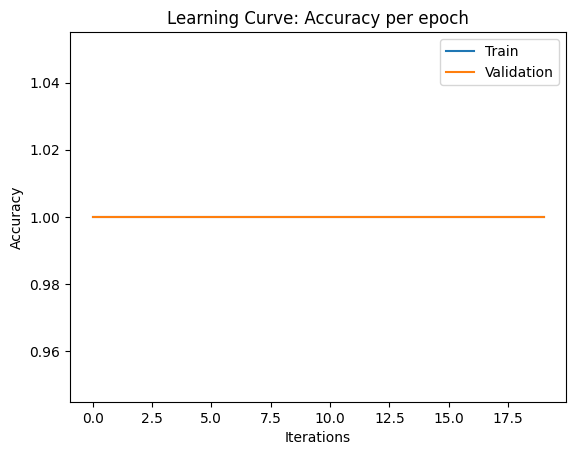

In [59]:
RH.plot_learning_curve(*try_train)

It seem that we overfitted well (f1 score of 1) and we are ready for training:

In [30]:
from pretrained.get_pretrained_roberta import GetPretrainedRoberta 
from pretrained.modify_roberta import ModifyRoberta

roberta_model = GetPretrainedRoberta()
ModifyRoberta.modify_binary_output(roberta_model.model) 
ModifyRoberta.modify_only_train_calssifier(roberta_model.model)

In [31]:
from roberta.roberta_handle import RobertaHandler as RH

handler = RH()

trained_model = handler.train_roberta_model(val_data=val_data ,batch_size=32, check_point_path=None, learning_rate=4e-4, num_epoches=100, train_data=train_data, model=roberta_model)


====> Epoch: 0 Average train loss: 0.0221, train acc: 0.4212, Average val loss: 0.0208, val acc: 0.3191
====> Epoch: 1 Average train loss: 0.0216, train acc: 0.0009, Average val loss: 0.0190, val acc: 0.0000
====> Epoch: 2 Average train loss: 0.0215, train acc: 0.1446, Average val loss: 0.0201, val acc: 0.1905
====> Epoch: 3 Average train loss: 0.0214, train acc: 0.3684, Average val loss: 0.0204, val acc: 0.1860
====> Epoch: 4 Average train loss: 0.0214, train acc: 0.0918, Average val loss: 0.0198, val acc: 0.0400
====> Epoch: 5 Average train loss: 0.0215, train acc: 0.0009, Average val loss: 0.0191, val acc: 0.0000
====> Epoch: 6 Average train loss: 0.0214, train acc: 0.0112, Average val loss: 0.0197, val acc: 0.0000
====> Epoch: 7 Average train loss: 0.0214, train acc: 0.0311, Average val loss: 0.0196, val acc: 0.0392
====> Epoch: 8 Average train loss: 0.0212, train acc: 0.5058, Average val loss: 0.0210, val acc: 0.3443
====> Epoch: 9 Average train loss: 0.0213, train acc: 0.0641, Av

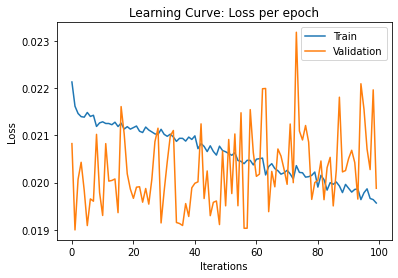

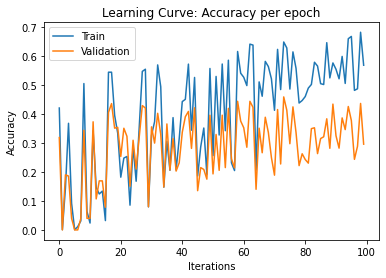

In [32]:
RH.plot_learning_curve(*trained_model)

In [ ]:
results = pd.read_csv(sample_submission_path)
results.target = clf.predict(count_vectorizer.transform(test_df["text"]))
results.to_csv("submission.csv", index=False)